<a href="https://colab.research.google.com/github/eric-r-xu/DiscardWisdom/blob/main/HKMahjong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
True
Screenshot Path: /content/drive/MyDrive/mahjong/examples/1.png
Template Directory: /content/drive/MyDrive/mahjong/hkmj_tile_templates/


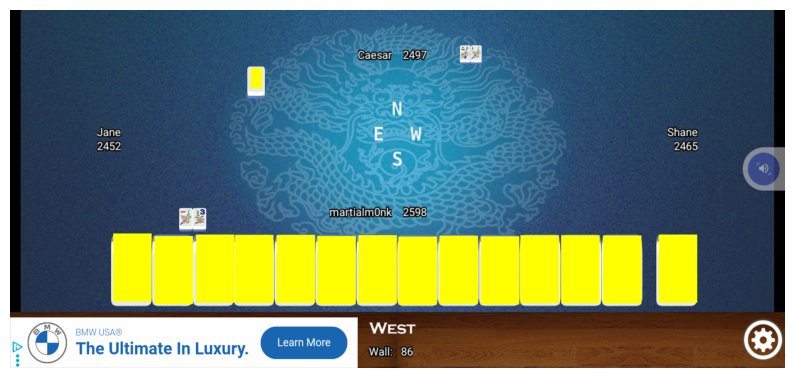


------------------------------------------'OVERALL'------------------------------------------


1 wdh tiles found


1 3b tiles found


1 8d tiles found


1 6b tiles found


2 9d tiles found


1 5d tiles found


1 6d tiles found


1 3d tiles found


1 4c tiles found


1 8b tiles found


1 3c tiles found


1 9c tiles found


1 swh tiles found


1 4b tiles found

player_you = defaultdict(<class 'int'>, {'wdh': 1, '3b': 1, '8d': 1, '6b': 1, '9d': 2, '5d': 1, '6d': 1, '3d': 1, '4c': 1, '8b': 1, '3c': 1, '9c': 1, 'swh': 1})
collective = defaultdict(<class 'int'>, {'4b': 1})
Made it to the bitter end!


In [22]:
import cv2
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt

def show_image(img, scale):
    resized_img = cv2.resize(
        img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA
    )
    # Convert BGR to RGB for displaying with matplotlib
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.show()

def init_screenshot(image_path):
    width, height = 2778, 1284
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error: Could not read the target image.")

    # Resize the image to the specified dimensions
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

    # Initialize a mask with the new dimensions
    mask = np.zeros((height, width), dtype=bool)

    return resized_image, mask

def find_and_print_locations(template_image, image, match_mask):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_template_gray = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)
    threshold = 0.8
    locations = 0

    resized_template = original_template_gray
    result = cv2.matchTemplate(image_gray, resized_template, cv2.TM_CCOEFF_NORMED)
    matches = np.where(result >= threshold)

    for y, x in zip(*matches):
        end_y, end_x = y + resized_template.shape[0], x + resized_template.shape[1]
        if np.any(match_mask[y:end_y, x:end_x]):
            continue
        match_mask[y:end_y, x:end_x] = True
        cv2.rectangle(image, (x, y), (end_x, end_y), (0, 255, 255), -1)
        locations += 1

    return locations

# Paths to your images (ensure these paths are correct in your Colab environment)
screenshot_path = "/content/drive/MyDrive/mahjong/examples/1.png"
template_dir = "/content/drive/MyDrive/mahjong/hkmj_tile_templates/"

# Uploading and mounting your files on Google Colab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
print(os.path.exists("/content/drive"))


print("Screenshot Path:", screenshot_path)
print("Template Directory:", template_dir)

template_files = [
    os.path.join(root, file)
    for root, dirs, files in os.walk(template_dir)
    for file in files
    if file.endswith((".PNG", ".png"))
]

image, match_mask = init_screenshot(screenshot_path)
templates = {file: cv2.imread(file) for file in template_files}

tiles_found = defaultdict(int)
collective = defaultdict(int)
player_you = defaultdict(int)

for template_path, template_image in templates.items():
    _template_id = template_path.split("/")[-3:]
    _player, _type, _tile = (
        _template_id[0],
        _template_id[1],
        _template_id[2].replace(".png", ""),
    )
    if template_image is None:
        print(f"Error: Could not read the template image at {template_path}")
        continue
    found_tiles = find_and_print_locations(template_image, image, match_mask)
    if found_tiles > 0:
        tiles_found[_tile] += found_tiles
        if _player == 'player_you':
            player_you[_tile] += found_tiles
        if _player == 'collective':
            collective[_tile] += found_tiles

# Create a semi-transparent overlay
overlay = image.copy()
highlight_color = (0, 255, 255)  # Yellow color for highlights

# Redraw the rectangles on the overlay
for template_path, template_image in templates.items():
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_template_gray = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)
    threshold = 0.8
    resized_template = original_template_gray
    result = cv2.matchTemplate(image_gray, resized_template, cv2.TM_CCOEFF_NORMED)
    matches = np.where(result >= threshold)

    for y, x in zip(*matches):
        end_y, end_x = y + resized_template.shape[0], x + resized_template.shape[1]
        if np.any(match_mask[y:end_y, x:end_x]):
            continue
        match_mask[y:end_y, x:end_x] = True
        cv2.rectangle(overlay, (x, y), (end_x, end_y), highlight_color, -1)

# Blend the overlay with the original image with 50% transparency
highlight_image = cv2.addWeighted(overlay, 0.5, image, 0.5, 0)

# Show the final highlighted image
show_image(highlight_image, 0.7)

print(
    f"\n------------------------------------------'OVERALL'------------------------------------------\n"
)
for k, v in tiles_found.items():
    print(f"\n{v} {k} tiles found\n")

print(f'player_you = {player_you}')
print(f'collective = {collective}')

print("Made it to the bitter end!")
